In [1]:
#!pip install gym
#!pip install pyyaml
#!pip install ipympl
#!pip install pandas

%matplotlib widget

In [2]:
from env.maze_env import MazeEnv
import matplotlib.pyplot as plt
from utils.visualizations import animate_agent_path, plot_value_map, show_runtime_table
from utils.metrics import evaluate_policy, time_algorithm
import yaml
from utils.run_policy import run_policy
import pandas as pd


# import agents 
from agents_algo import dp_agent as dp
from agents_algo import monte_carlo_agent as mc
from agents_algo import td0_agent as td
from agents_algo import q_learning_agent as ql
from agents_algo import sarsa_agent as sa
from agents_algo import td_lambda_agent as td_lambda




In [3]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

env = MazeEnv()



### 1. Dynammic Programming (DP)

$$
V(s) \leftarrow \max_{a \in \mathcal{A}(s)} \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma V(s') \right]
$$


where the transition function is known and each state is known, thus:
$$ P(s' \mid s, a) = 1 $$ 
Meaning we know the probability in each state, what will be the probability for the next state.

[DP] gamma=0.9, theta=0.0001 (type: <class 'float'>)
 Convergence Iterations: 10
 Runtime: 0.0168 seconds
 Average Reward: 0.920


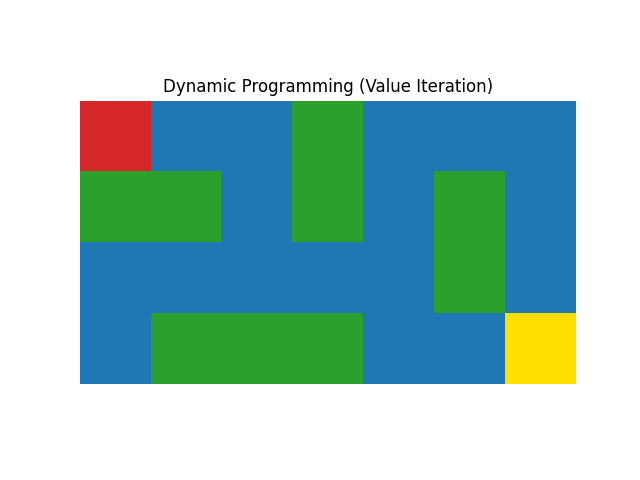

In [4]:
# --- Run DP and track time ---
(result, runtime_dp) = time_algorithm(lambda: dp.value_iteration(env))
policy, value_table, iterations = result

# --- Evaluate policy ---
avg_reward, reward_per_episode = evaluate_policy(env, policy)

# --- Print Metrics ---
print(f" Convergence Iterations: {iterations}")
print(f" Runtime: {runtime_dp:.4f} seconds")
print(f" Average Reward: {avg_reward:.3f}")

# --- Visualize ---
path = run_policy(env, policy)
animate_agent_path(env, path, title="Dynamic Programming (Value Iteration)")


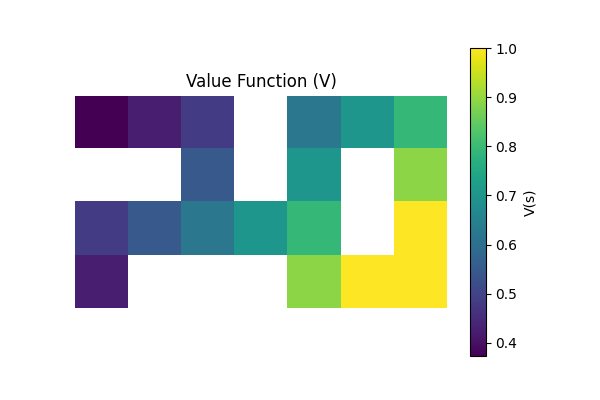

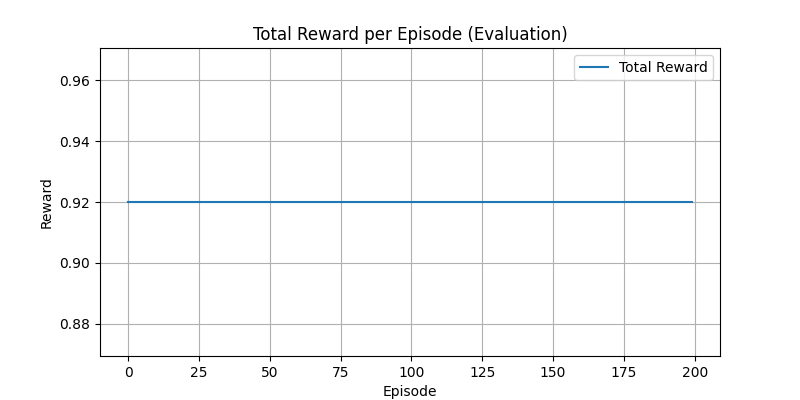

In [5]:
plot_value_map(env, value_table, title="Value Function (V)")

# --- Plot reward trend (even if static in DP) ---
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode, label="Total Reward")
plt.title("Total Reward per Episode (Evaluation)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

### Monte Carlo Control: Core Equations

We aim to learn the optimal action-value function \( Q(s, a) \) by averaging sampled returns \( G_t \) over episodes.

#### 1. Return:
The return \( G_t \) is the total discounted reward from time step \( t \) to the end of the episode:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots + \gamma^{T - t - 1} r_T = \sum_{k=0}^{T - t - 1} \gamma^k r_{t+k+1}
$$

#### 2. Q-value Update Rule:
Using **first-visit Monte Carlo**, we update the Q-value incrementally:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left( G_t - Q(s, a) \right)
$$

$ \alpha$ : learning rate  
$G_t$: return observed from time \( t \)  
$Q(s, a)$: estimate of expected return from taking action \( a \) in state \( s \)

#### 3. Policy (ε-greedy):
The policy is updated using an ε-greedy strategy over the Q-values:

$$
\pi(s) = 
\begin{cases}
\text{argmax}_a \, Q(s, a) & \text{with probability } 1 - \epsilon \\
\text{random action} & \text{with probability } \epsilon
\end{cases}
$$

This ensures exploration while still favoring actions with high estimated value.

#### Notes:
- Monte Carlo methods are model-free and require complete episodes.
- They converge as more episodes are sampled, averaging out the true expected return.


In [6]:

# --- Run Monte Carlo and track time ---
(result, runtime_mc) = time_algorithm(lambda: mc.train_monte_carlo(env))
policy, value_table, q_table, reward_per_episode, convergence_ep = result

# --- Evaluate policy ---
avg_reward, _ = evaluate_policy(env, policy)

# --- Print Metrics ---
print(f"Converged at episode: {convergence_ep}")
print(f"Runtime: {runtime_mc:.4f} seconds")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

# --- Visualize path ---
path = run_policy(env, policy)
#animate_agent_path(env, path, title="Monte Carlo Agent Path")


Converged at episode: 20
Runtime: 0.5689 seconds
Average Evaluation Reward: 0.880


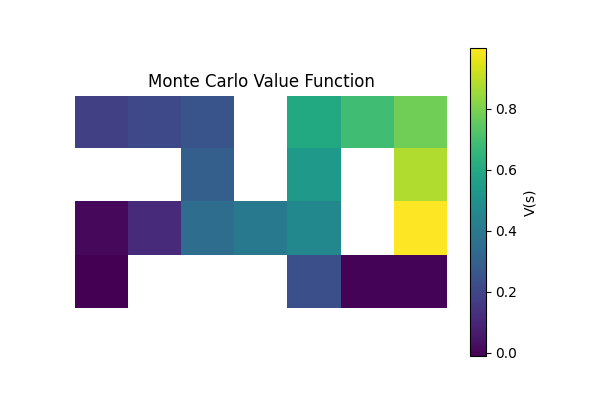

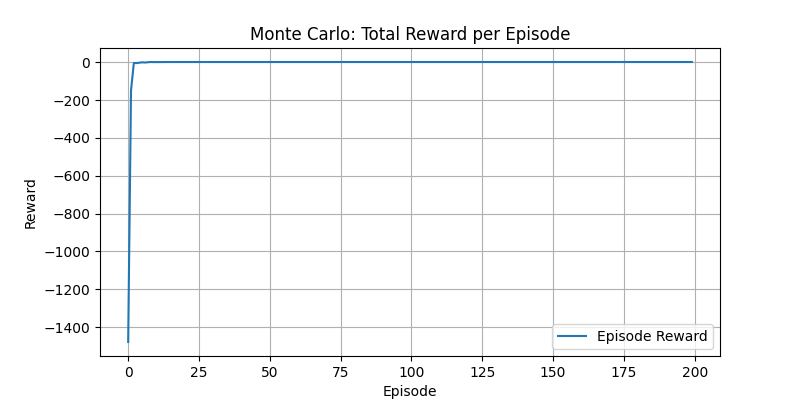

In [7]:
plot_value_map(env, value_table, title="Monte Carlo Value Function")

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode, label="Episode Reward")
plt.title("Monte Carlo: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


### 3. Temporal Difference Learning (TD(0))

Temporal Difference (TD) Learning is a model-free reinforcement learning method that updates the value of a state based on the reward received and the estimated value of the next state. It combines ideas from both Monte Carlo methods and Dynamic Programming.

#### TD(0) Update Rule

After taking action at time $t$, we observe reward $r_{t+1}$ and next state $s_{t+1}$.  
We update the value function $V(s)$ using the TD(0) rule:

$$
V(s_t) \leftarrow V(s_t) + \alpha \left( r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \right)
$$

####  Parameters:
- $\alpha$: Learning rate  
- $\gamma$: Discount factor  
- $r_{t+1}$: Reward received after taking action at $s_t$  
- $V(s_t)$: Current estimate of the value of state $s_t$  
- $V(s_{t+1})$: Estimated value of the next state  

####  TD Error

The quantity inside the update is called the **TD error**:

$$
\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)
$$

We use this to update the value function:

$$
V(s_t) \leftarrow V(s_t) + \alpha \cdot \delta_t
$$


In [8]:

# Train TD(0) value estimator
(V, reward_per_episode), runtime_td0 = time_algorithm(lambda: td.train_td0(env))

# Extract policy after learning V(s)
policy = td.extract_policy(env, V, gamma=0.9)

# Evaluate and visualize
avg_reward, _ = evaluate_policy(env, policy)
path = run_policy(env, policy)

print(f"Runtime: {runtime_td0:.3f}s")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

#animate_agent_path(env, path, title="TD(0) Agent Path")


Runtime: 0.619s
Average Evaluation Reward: 0.920


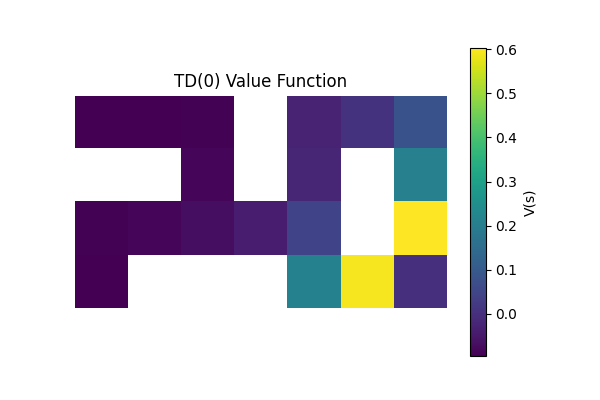

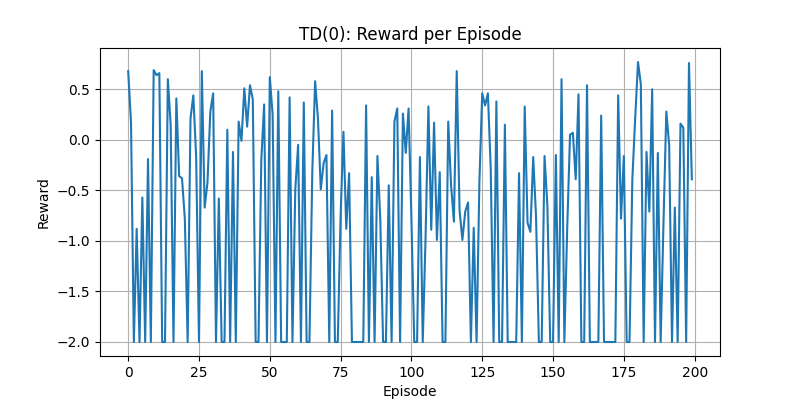

In [9]:
plot_value_map(env, V, title="TD(0) Value Function")

# Plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.title("TD(0): Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

### 4. Q-Learning

Q-Learning is an off-policy, model-free reinforcement learning algorithm that learns the optimal action-value function, denoted by $Q^*(s, a)$.

It uses the **Bellman optimality equation** to update the Q-values based on interaction with the environment.

####  Q-Learning Update Rule

At each time step $t$, after observing transition $(s_t, a_t, r_{t+1}, s_{t+1})$, the Q-value is updated as:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

- $\alpha$: Learning rate ($0 < \alpha \leq 1$)
- $\gamma$: Discount factor ($0 \leq \gamma \leq 1$)
- $r_{t+1}$: Reward received after taking action $a_t$ in state $s_t$
- $s_{t+1}$: Next state after action
- $\max_a Q(s_{t+1}, a)$: Estimated value of the best action in the next state (greedy choice)



####  ε-Greedy Policy for Exploration

To balance exploration and exploitation:

- With probability $\epsilon$, choose a **random** action
- With probability $1 - \epsilon$, choose:

$$
a = \arg\max_a Q(s, a)
$$

This encourages the agent to explore new actions while gradually favoring the best-known ones.

---

####  Goal of Q-Learning

By continually updating $Q(s, a)$ and acting $\epsilon$-greedily, the agent converges toward the **optimal action-value function** $Q^*(s, a)$:

$$
\pi^*(s) = \arg\max_a Q^*(s, a)
$$



In [10]:

# Run and time Q-learning
(result, runtime_q) = time_algorithm(lambda: ql.train_q_learning(env))
policy, value_table, q_table, reward_per_episode, convergence_ep = result

# Evaluate final policy
avg_reward, _ = evaluate_policy(env, policy)
path = run_policy(env, policy)

# Print metrics
print(f"Q-learning converged at episode: {convergence_ep}")
print(f"Runtime: {runtime_q:.4f} seconds")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

# Visualize
#animate_agent_path(env, path, title="Q-learning Agent Path")


Q-learning converged at episode: 32
Runtime: 0.0745 seconds
Average Evaluation Reward: 0.920


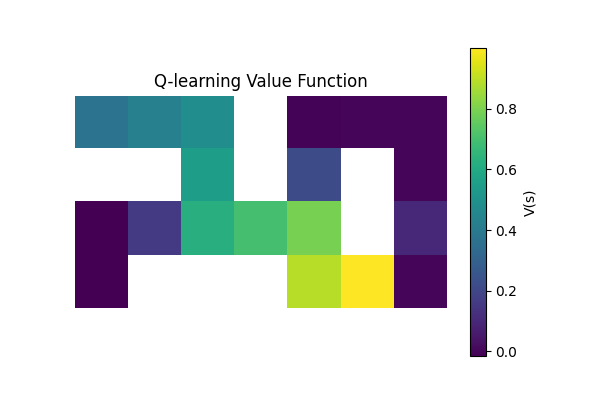

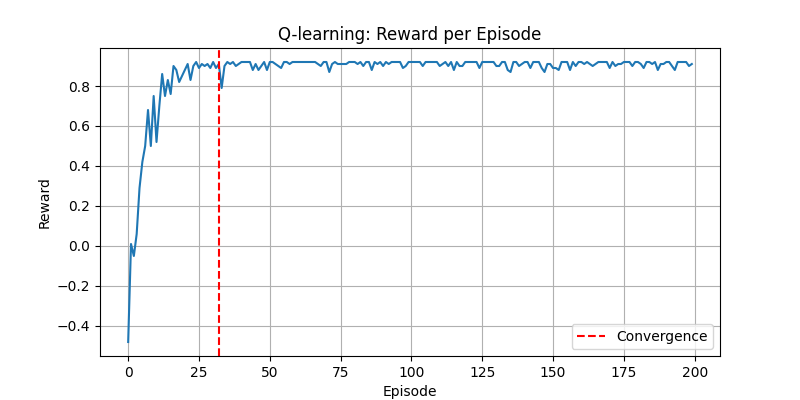

In [11]:
plot_value_map(env, value_table, title="Q-learning Value Function")

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.axvline(convergence_ep, color="red", linestyle="--", label="Convergence")
plt.title("Q-learning: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

### 5. SARSA: On-Policy Temporal Difference Control

**SARSA** (State–Action–Reward–State–Action) is an **on-policy** reinforcement learning algorithm that learns the value of the **policy it is actually following** (usually an ε-greedy policy).

---

#### Update Rule

After observing a transition tuple $(s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1})$, SARSA updates the action-value function as follows:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

- $s_t$: current state  
- $a_t$: action taken in $s_t$  
- $r_{t+1}$: reward received after taking $a_t$  
- $s_{t+1}$: next state  
- $a_{t+1}$: next action taken in $s_{t+1}$  
- $\alpha$: learning rate  
- $\gamma$: discount factor

---

#### Key Properties

- **On-policy**: learns the value of the behavior policy (e.g., ε-greedy)
- **Bootstrapping**: updates based on the next estimate $Q(s_{t+1}, a_{t+1})$
- **Exploration-aware**: the update reflects the real behavior, including randomness

---

#### Comparison with Q-Learning

| Aspect             | SARSA                                        | Q-Learning                                   |
|--------------------|----------------------------------------------|-----------------------------------------------|
| Type               | On-policy                                    | Off-policy                                    |
| Target             | $Q(s_{t+1}, a_{t+1})$ (actual next action)   | $\max_a Q(s_{t+1}, a)$ (greedy best action)   |
| Learning about     | The policy the agent follows                 | The optimal policy, regardless of behavior    |
| Exploration-safe   | Yes                                          | No — can overestimate                         |

---

#### Goal of SARSA

SARSA aims to learn the optimal action-value function $Q^*(s, a)$ by repeatedly evaluating and improving the **policy the agent is actually executing**.


In [12]:

# Run and time SARSA
(result, runtime_sarsa) = time_algorithm(lambda: sa.train_sarsa(env))
policy, value_table, q_table, reward_per_episode, convergence_ep = result

# Evaluate the learned policy
avg_reward, _ = evaluate_policy(env, policy)
path = run_policy(env, policy)

# Print metrics
print(f"SARSA converged at episode: {convergence_ep}")
print(f"Runtime: {runtime_sarsa:.4f} seconds")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

# Visualize results
#animate_agent_path(env, path, title="SARSA Agent Path")


SARSA converged at episode: 32
Runtime: 0.0458 seconds
Average Evaluation Reward: 0.920


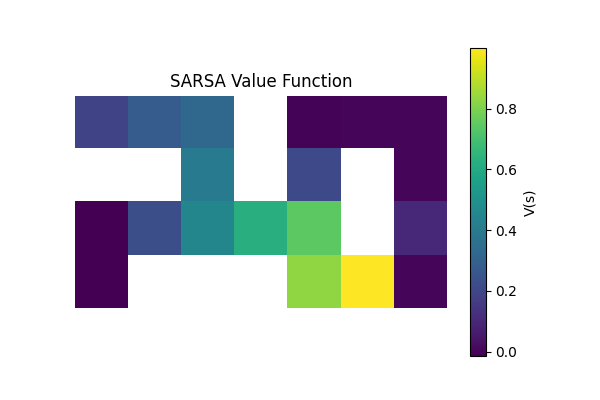

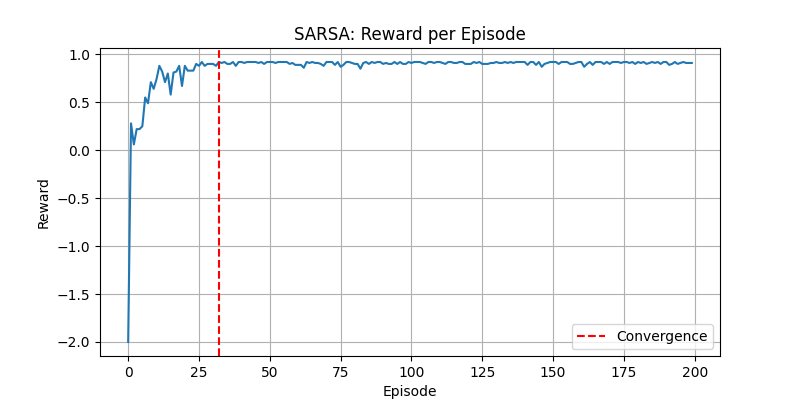

In [13]:
plot_value_map(env, value_table, title="SARSA Value Function")

plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.axvline(convergence_ep, color="red", linestyle="--", label="Convergence")
plt.title("SARSA: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

### 6. TD(λ): Temporal Difference Learning with Eligibility Traces

**TD(λ)** is an extension of Temporal Difference (TD) learning that blends **TD(0)** and **Monte Carlo** methods by using a parameter λ (lambda) to balance short-term and long-term credit assignment.

#### Goal

Estimate the state-value function $V(s)$ using a combination of immediate and future returns.

---

#### Core Idea

TD(λ) introduces **eligibility traces**, which track how "eligible" a state is to receive credit from the TD error.  
Each state accumulates trace values as it is visited and decays over time:

- Recent states get **higher credit**
- Earlier states get **smaller but non-zero credit**

---

#### TD(λ) Update Rule

At each time step $t$, after transitioning from $s_t$ to $s_{t+1}$ with reward $r_{t+1}$:

1. Compute the **TD error**:
$$
\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)
$$

2. Update the **eligibility trace** for all states:
$$
E(s) \leftarrow \gamma \lambda E(s)
$$
$$
E(s_t) \leftarrow E(s_t) + 1
$$

3. Update the value function for all states:
$$
V(s) \leftarrow V(s) + \alpha \cdot \delta_t \cdot E(s)
$$

---

#### Parameters

- $\alpha$: Learning rate  
- $\gamma$: Discount factor  
- $\lambda$: Trace-decay parameter ($0 \leq \lambda \leq 1$)  
- $E(s)$: Eligibility trace for each state

---

#### Relationship to Other Methods

- If $\lambda = 0$ → TD(λ) becomes **TD(0)**
- If $\lambda = 1$ (and episode ends) → TD(λ) becomes similar to **Monte Carlo**

---

#### Intuition

TD(λ) distributes the TD error **backward** in time to all previously visited states, with exponentially decreasing weight.

This improves **credit assignment** and leads to faster convergence compared to pure TD(0) or MC methods.




Training TD(λ) with λ = 0.20

Training TD(λ) with λ = 0.50

Training TD(λ) with λ = 0.80
λ = 0.20 | Converged at episode: 200 | Avg Reward: 0.920 | Runtime: 0.7158 sec


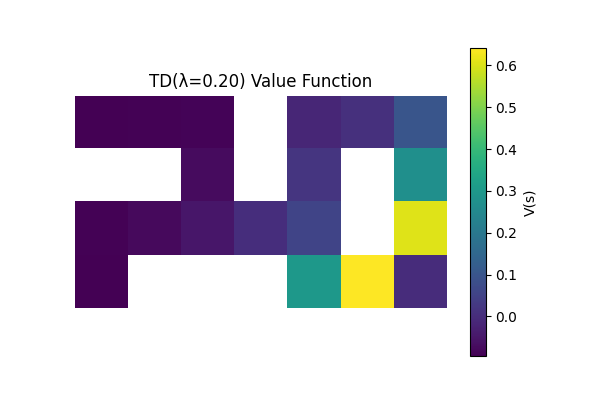

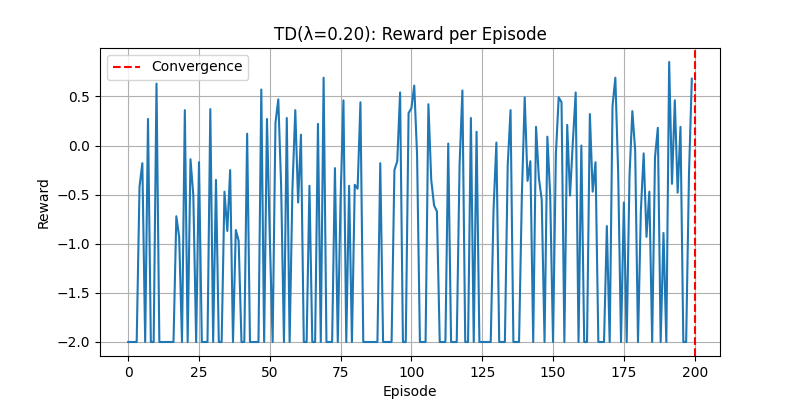

λ = 0.50 | Converged at episode: 200 | Avg Reward: 0.920 | Runtime: 0.3747 sec


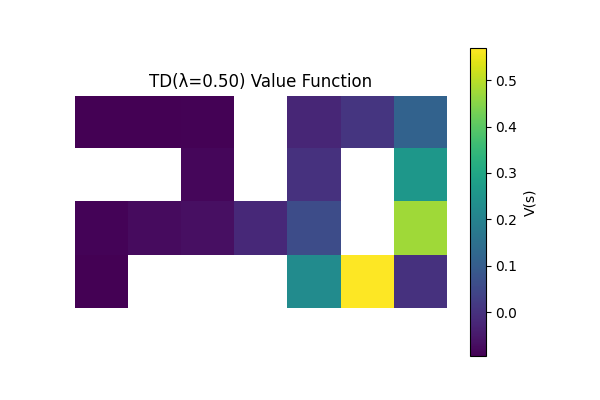

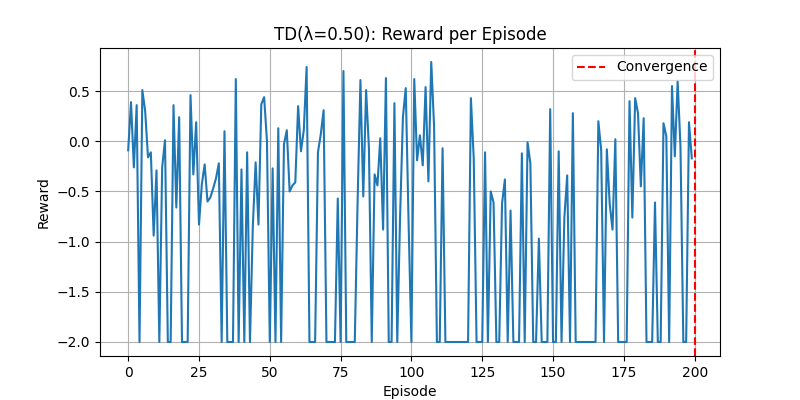

λ = 0.80 | Converged at episode: 200 | Avg Reward: 0.920 | Runtime: 0.3543 sec


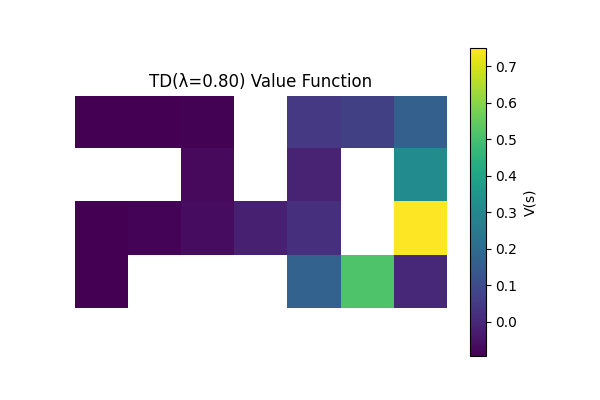

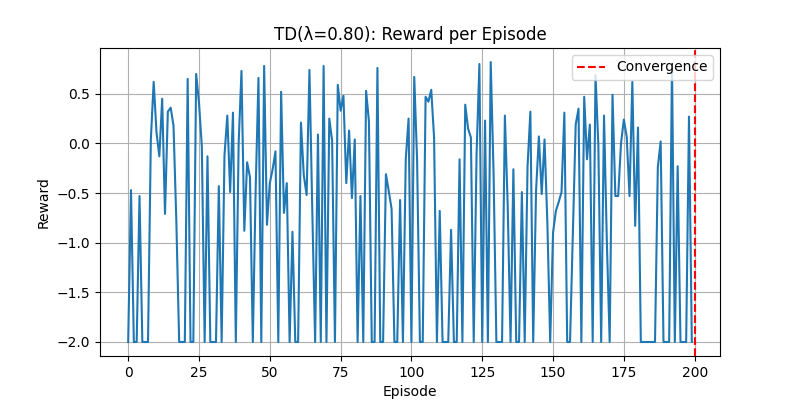

In [14]:
lambda_values = [0.2, 0.5, 0.8]

results = []
runtimes_td_lambda = []

for lambd in lambda_values:
    print(f"\nTraining TD(λ) with λ = {lambd:.2f}")

    # Time the full training for this λ
    def train_one_lambda():
        return td_lambda.train_td_lambda(env, lambd)
    
    result, runtime = time_algorithm(train_one_lambda)

    # Add metadata for this run
    result["lambda"] = lambd
    result["runtime"] = runtime
    results.append(result)
    runtimes_td_lambda.append(runtime)
    
# Loop to evaluate and visualize each result
for result in results:
    lambd = result["lambda"]
    policy = result["policy"]
    value_table = result["value_table"]
    rewards = result["rewards"]
    convergence_ep = result["convergence_ep"]
    runtime = result["runtime"]

    avg_reward, _ = evaluate_policy(env, policy)
    path = run_policy(env, policy)

    print(f"λ = {lambd:.2f} | Converged at episode: {convergence_ep} | "
          f"Avg Reward: {avg_reward:.3f} | Runtime: {runtime:.4f} sec")

    #animate_agent_path(env, path, title=f"TD(λ={lambd:.2f}) Agent Path")
    plot_value_map(env, value_table, title=f"TD(λ={lambd:.2f}) Value Function")

    plt.figure(figsize=(8, 4))
    plt.plot(rewards)
    plt.axvline(convergence_ep, color="red", linestyle="--", label="Convergence")
    plt.title(f"TD(λ={lambd:.2f}): Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

### Results Comparison

#### - Convergence

In [16]:
show_runtime_table(runtime_dp, runtime_mc, runtime_td0, runtime_q, runtime_sarsa, runtimes_td_lambda)


### Runtimes of the Algorithms (from Fastest to Slowest):


,Algorithm,Runtime (seconds)
0,DP,0.016807
1,SARSA,0.045825
2,Q-learning,0.074542
3,TD(λ=0.8),0.354264
4,TD(λ=0.5),0.374711
5,Monte Carlo,0.568895
6,TD(0),0.619323
7,TD(λ=0.2),0.715829


The model that converges the **fastest** is the dynamic programming. It is no surprise becuase:

* It is model-based. DP has access to the full transition model and reward function of the environment.


* It does not rely on sampling or exploration — it "knows" the effect of each action at every state.


On the other hand, Monte Carlo, which performed the **slowest**:
* Is a model free algorithm. It must learn from samples and full episodes.
* It needs many interactions with the environment to gather information.
* It improves gradually, often with exploration (ε-greedy).

### How Do Parameters Affect Convergence?

The choice of parameters — discount factor $\gamma$ , learning rate $\alpha$, and trace decay  $\lambda$ — greatly influences convergence behavior.

---

#### 1. Discount Factor

$$
\gamma \in [0, 1]
$$

- Low $\gamma$ (0.1–0.5):  
  Focuses on short-term rewards → faster convergence but ignores long-term outcomes.

- High $\gamma$ (0.9–0.99):  
  Encourages long-term planning → better results but potentially slower or unstable convergence.

The return is:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots
$$

---

#### 2. Learning Rate

$$
\alpha \in [0, 1]
$$

- High $\alpha$ (0.5–1.0):  
  Fast learning → can cause overshooting and instability.

- Low $\alpha$ (0.01–0.1):  
  Slow but stable convergence.

Update rule:

$$
V(s) \leftarrow V(s) + \alpha \cdot \delta
$$

---

#### 3. Eligibility Trace Decay

$$
\lambda \in [0, 1]
$$

- $\lambda = 0$:  
  Pure TD(0) — fast but limited credit assignment.

- $\lambda = 1$:  
  Monte Carlo — full return but high variance.

- Intermediate values (0.5–0.8):  
  Balance bias and variance, often yielding faster and more stable convergence.

---

#### Summary Table

| Parameter | Role                          | Effect of High Value                        | Effect of Low Value                  |
|-----------|-------------------------------|---------------------------------------------|--------------------------------------|
| $\gamma$  | Discount future rewards       | Long-term focus, but slower/stable updates | Short-sighted behavior               |
| $\alpha$  | Step size in updates         | Fast learning, but risk of divergence       | Stable but slow learning             |
| $\lambda$ | Credit assignment over time  | Accurate crediting, but noisy updates       | Only immediate steps get updated     |


### - Handling Delayed Rewards

### 2. Handling Delayed Rewards

#### Which algorithm handles delayed rewards most effectively? Why?

Among all six algorithms, **TD(λ)** handles delayed rewards **most effectively** because it assigns credit backward through multiple time steps using **eligibility traces**. This allows the agent to update the value of previously visited states based on rewards that arrive much later in time.

---

#### Comparison: How Each Algorithm Handles Delayed Rewards

| Algorithm       | Update Timing           | Handles Delayed Rewards | Notes |
|-----------------|--------------|--------------------------|--------------------------|-------|
| **DP**          | Full backups             | ✅ Excellent              | Uses known model to propagate rewards globally |
| **Monte Carlo** | End of episode           | ✅ Good                   | Can credit all past states, but must wait for episode end |
| **TD(0)**       | One-step bootstrapping   | ❌ Poor                   | Only updates based on immediate next state |
| **Q-learning**   | Off-policy, one-step     | ⚠️ Moderate               | Delayed rewards only affect states visited directly |
| **SARSA**        | On-policy, one-step      | ⚠️ Moderate               | Similar to Q-learning; relies on current trajectory |
| **TD(λ)**        | Multi-step bootstrapping | ✅ **Best**               | Uses eligibility traces for multi-step credit assignment |

---

#### Why TD(λ) Is Best for Delayed Rewards

TD(λ) blends TD(0) and Monte Carlo methods by using a decaying memory of past states (via eligibility traces). It can update not just the current state, but all previously visited states proportionally.

The core equations:

$$
\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)
$$

$$
E(s_t) \leftarrow E(s_t) + 1
$$

$$
V(s) \leftarrow V(s) + \alpha \cdot \delta_t \cdot E(s)
$$

$$
E(s) \leftarrow \gamma \cdot \lambda \cdot E


 ### - Exploration vs. Exploitation:


### How do Q-Learning and SARSA differ in balancing exploration and exploitation?

#### Q-Learning

Q-Learning is an off-policy algorithm.  
It learns the value of the optimal policy, regardless of the policy being followed during training. It assumes that in the next state  $s'$, the agent will always choose the best possible action, even if it actually behaves differently (explores randomly).

The update rule is:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

- Ignores the actual next action taken during exploration.
- Optimistic updates based on the best estimated future reward.
- Tends to converge quickly but can be risky during learning.

---

#### SARSA

SARSA is an on-policy algorithm.  
It learns the value of the current behavior policy, which includes exploration (an $\epsilon$-greedy strategy). It updates Q-values based on the actual action taken in the next state.

The update rule is:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]
$$

- Updates are based on the trajectory the agent actually follows.
- Incorporates the effect of exploration into learning.
- Leads to safer and more conservative policies.

---

### In what scenarios does SARSA outperform Q-Learning?

SARSA outperforms Q-Learning in **environments where exploration can be dangerous**, such as:

- Stochastic or noisy environments with unpredictable outcomes.
- Environments with cliffs, traps, or heavy penalties.
- Applications where safe behavior during learning is critical, such as robotics or healthcare.

SARSA naturally learns to be more cautious by considering the outcomes of exploratory actions, while Q-Learning may assume perfect greedy behavior and overestimate action values.



### - Computational Complexity

### Computational Complexity

#### Which algorithm is the most computationally efficient? Why?

**Dynamic Programming (DP)** is typically the most computationally efficient **per iteration**, because:

- It performs synchronous updates over all states using a known transition model.
- There is no need for sampling, exploration, or episode simulation.
- Each state is updated once per iteration using closed-form expectations.

Thus, if the environment model is available, DP can converge in a few iterations with minimal variance.

However, in practice:
- DP requires full knowledge of the environment, which is often unrealistic.
- Model-free methods (like Q-Learning and SARSA) are more flexible but require many interactions to learn from experience.

---



#### How does the use of eligibility traces in TD(λ) impact memory and runtime?

In TD(λ), the agent maintains an eligibility trace $E(s)$ for every state (or $E(s, a)$ if using action-value traces).

At each time step:

- The TD error $\delta_t$ is computed:

$$
\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)
$$

- The trace is updated:

$$
E(s_t) \leftarrow E(s_t) + 1
$$

$$
E(s) \leftarrow \gamma \lambda E(s) \quad \text{for all } s
$$

- The value function is updated for all states:

$$
V(s) \leftarrow V(s) + \alpha \cdot \delta_t \cdot E(s)
$$

This means:

- Memory usage is $O(|S|)$ due to the eligibility trace vector.
- Computation per step is also $O(|S|)$, since each update depends on all traces.
- Compared to TD(0), this adds a linear overhead in state space size.

While TD(λ) increases computational and memory cost, it often converges faster in terms of total episodes or samples due to more effective credit assignment.

In my experiment the results of the various $\lambda$ values were:
λ = 0.20 - Runtime: 0.7158 sec
λ = 0.50 - Runtime: 0.3747 sec
λ = 0.80 - Runtime: 0.3543 sec

Neither of the experiments did not converged to a stable learning. Although we can see that
by using a higher λ, the runtime gets faster. 

---

#### Conclusion

- DP is most computationally efficient when the model is known.
- TD(λ) is more expensive per step than TD(0), but often converges in fewer episodes.
- There is a trade-off between per-step complexity and total learning efficiency.
